In [62]:
import numpy as np
from CT import *
import matplotlib.pyplot as plt

In [63]:
def run_quantum(inputs):
    L,p_ctrl,p_proj,idx=inputs
    ct=CT_quantum(L=L,x0=None,seed=idx,history=False)
    # for ii in range(100):
    for _ in range(2*ct.L**2):
        ct.random_control_2(p_ctrl=p_ctrl,p_proj=p_proj)
    O=ct.order_parameter()
    SA=ct.half_system_entanglement_entropy()
    return O,SA

In [64]:
def rescale(x,alpha):
    '''rescale the granularity near (a+b)/2, where a, b are boundary of the range x '''
    a,b=min(x),max(x)
    x1=(x-a)*2/(b-a)-1
    y1=np.sign(x1)*np.abs(x1)**alpha
    return (y1+1)*(b-a)/2+a

In [65]:
from ipyparallel import Client
client = Client()

In [69]:
dview = client[:]

In [70]:
dview.execute('import numpy as np').wait()
dview.execute('from CT import *').wait()

True

## p_ctrol=1, sweep L

In [7]:
L_list=np.array([6,8,10,12,14,16])
# p_ctrl_list=np.linspace(.0,1,11)
# p_ctrl_list=rescale(p_ctrl_list, 2)
ensemble=2000
inputs=[(L,1,0,idx) for L in L_list for idx in range(ensemble)]

## fix p_proj, sweep p_ctrol for different L

In [71]:
L_list=np.array([10,12,14,16])
p_ctrl_list=np.linspace(.0,1,11)
p_ctrl_list=rescale(p_ctrl_list, 2)
ensemble=2000
inputs=[(L,p_ctrl,0,idx) for L in L_list for p_ctrl in p_ctrl_list for idx in range(ensemble)]

## parallel run

In [72]:
results = dview.map_async(run_quantum, inputs)

In [73]:
len(inputs)

88000

In [79]:
results.progress

88000

In [78]:
results.elapsed

1218.613575

## p_ctrol=1, sweep L

In [18]:
rs=np.array(list(results)).reshape((L_list.shape[0],ensemble,2))
O_map,EE_map=rs[:,:,0],rs[:,:,1]

Text(0, 0.5, '$\\overline{\\langle O \\rangle}$')

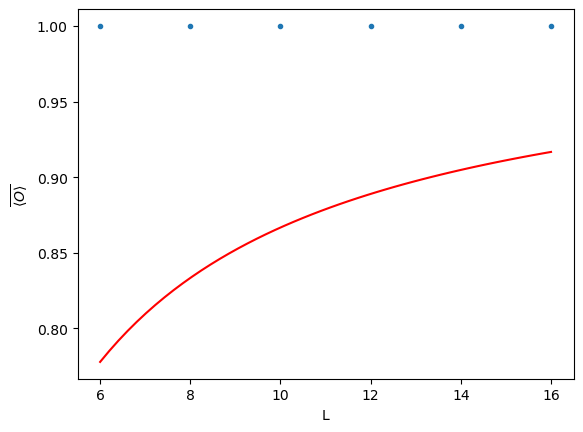

In [19]:
fig,ax=plt.subplots()
ax.plot(L_list,O_map.mean(axis=-1),'.')
L_list_cont=np.linspace(6,16)
ax.plot(L_list_cont,1-4/(3*(L_list_cont)),color='r',label='')
ax.set_xlabel('L')
ax.set_ylabel(r'$\overline{\langle O \rangle}$')

## p_proj=0, sweep p_ctrol for different L

In [80]:
rs=np.array(list(results)).reshape((L_list.shape[0],p_ctrl_list.shape[0],ensemble,2))

In [81]:
O_map,EE_map=rs[:,:,:,0],rs[:,:,:,1]

(0.0, 1.0)

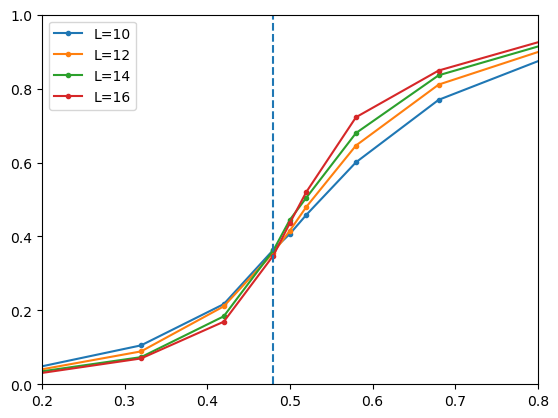

In [84]:
fig,ax=plt.subplots()
for i in range(O_map.shape[0]):
    ax.plot(p_ctrl_list,O_map[i].mean(axis=-1),'.-',label=f'L={L_list[i]}')
ax.legend()
ax.axvline(x=0.48,ls='dashed')
# ax.axhline(y=0.5)
ax.set_xlim([.2,.8])
ax.set_ylim([0,1])

(0.0, 1.0)

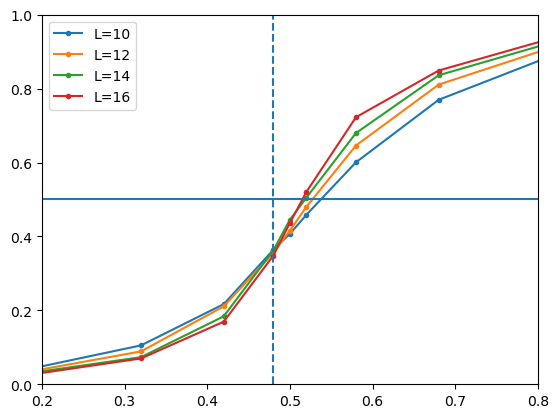

In [ ]:
fig,ax=plt.subplots()
for i in range(O_map.shape[0]):
    ax.plot(p_ctrl_list,O_map[i].mean(axis=-1),'.-',label=f'L={L_list[i]}')
ax.legend()
ax.axvline(x=0.48,ls='dashed')
ax.axhline(y=0.5)
ax.set_xlim([.2,.8])
ax.set_ylim([0,1])

(0.2, 0.8)

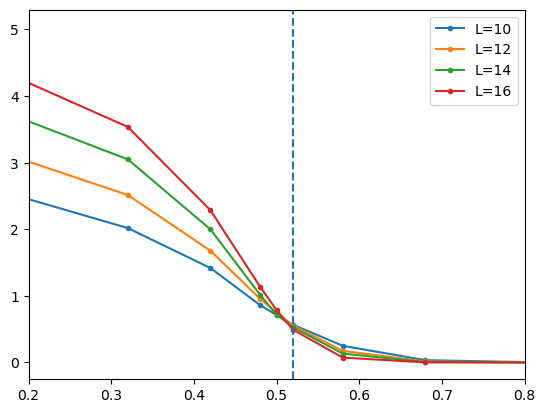

In [83]:
fig,ax=plt.subplots()
for i in range(EE_map.shape[0]):
    ax.plot(p_ctrl_list,EE_map[i].mean(axis=-1),'.-',label=f'L={L_list[i]}')
ax.legend()
ax.axvline(x=0.52,ls='dashed')
ax.set_xlim([.2,.8])

(0.2, 0.8)

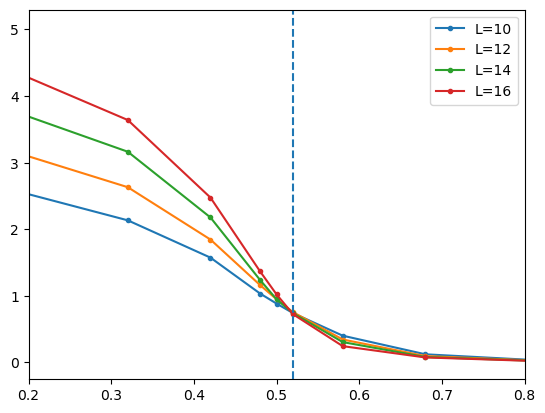

In [ ]:
fig,ax=plt.subplots()
for i in range(EE_map.shape[0]):
    ax.plot(p_ctrl_list,EE_map[i].mean(axis=-1),'.-',label=f'L={L_list[i]}')
ax.legend()
ax.axvline(x=0.52,ls='dashed')
ax.set_xlim([.2,.8])

(0.2, 0.8)

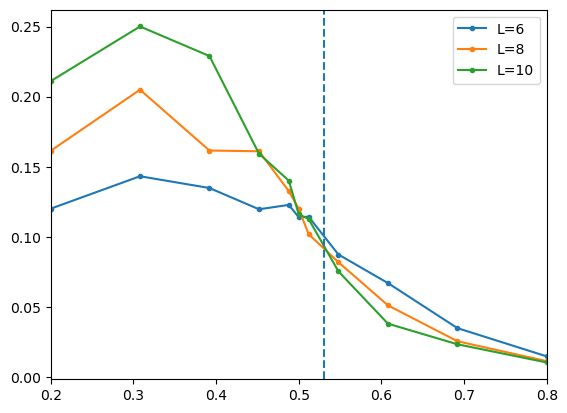

In [ ]:
fig,ax=plt.subplots()
for i in range(EE_map.shape[0]):
    ax.plot(p_ctrl_list,EE_map[i].mean(axis=-1),'.-',label=f'L={L_list[i]}')
ax.legend()
ax.axvline(x=0.53,ls='dashed')
ax.set_xlim([.2,.8])

In [ ]:
rho=(np.tensordot(ct.vec.conj(),ct.vec,axes=0))

In [ ]:
L_list=np.array([10,12,14,16])
p_ctrl_list=np.linspace(0.2,0.8,11)
p_proj_list=np.linspace(0,0.1,5)
ensemble=1000
inputs=[(L,p_ctrl,p_proj,idx) for L in L_list for p_ctrl in p_ctrl_list for p_proj in p_proj_list for idx in range(ensemble)]

In [ ]:
results = dview.map_async(run_quantum, inputs)

In [ ]:
len(inputs)

220000

In [ ]:
results.progress

220000

In [ ]:
results.elapsed

2581.638699

In [ ]:
np.array(list(results)).shape

(220000, 2)

In [ ]:
rs=np.array(list(results)).reshape((L_list.shape[0],p_ctrl_list.shape[0],p_proj_list.shape[0],ensemble,2))

In [ ]:
O_map,EE_map=rs[:,:,:,:,0],rs[:,:,:,:,1]

In [ ]:
O_map.shape

(4, 11, 5, 1000)

Text(0.5, 1.0, '$p_{proj}=0.000$')

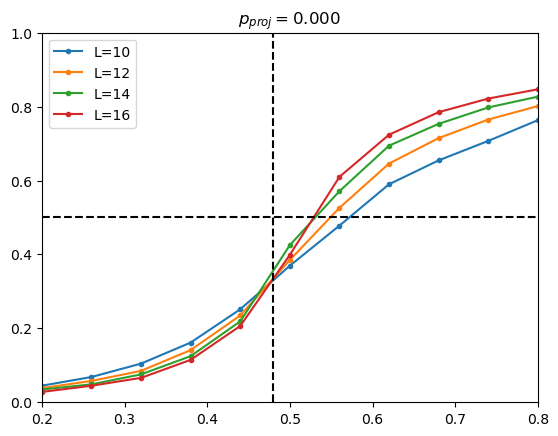

In [ ]:
fig,ax=plt.subplots()
p_proj_idx=0
for i in range(O_map.shape[0]):
    ax.plot(p_ctrl_list,O_map[i,:,p_proj_idx].mean(axis=-1),'.-',label=f'L={L_list[i]}')
ax.legend()
ax.axvline(x=0.48,ls='dashed',color='k')
ax.axhline(y=0.5,ls='dashed',color='k')
ax.set_xlim([.2,.8])
ax.set_ylim([0,1])
ax.set_title(f'$p_{{proj}}={p_proj_list[p_proj_idx]:.3f}$')

Text(0.5, 1.0, '$p_{proj}=0.025$')

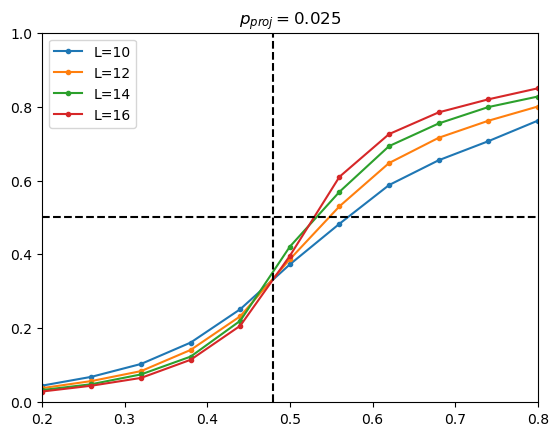

In [ ]:
fig,ax=plt.subplots()
p_proj_idx=1
for i in range(O_map.shape[0]):
    ax.plot(p_ctrl_list,O_map[i,:,p_proj_idx].mean(axis=-1),'.-',label=f'L={L_list[i]}')
ax.legend()
ax.axvline(x=0.48,ls='dashed',color='k')
ax.axhline(y=0.5,ls='dashed',color='k')
ax.set_xlim([.2,.8])
ax.set_ylim([0,1])
ax.set_title(f'$p_{{proj}}={p_proj_list[p_proj_idx]:.3f}$')

Text(0.5, 1.0, '$p_{proj}=0.050$')

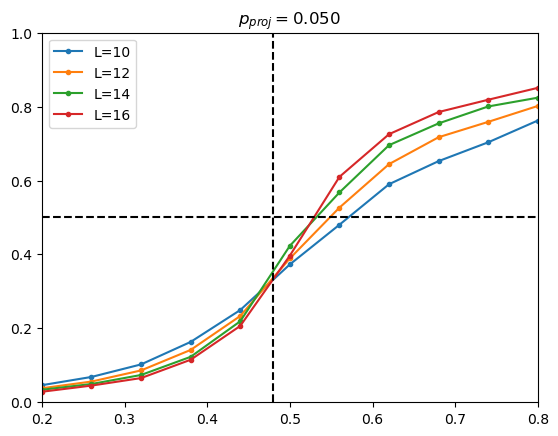

In [ ]:
fig,ax=plt.subplots()
p_proj_idx=2
for i in range(O_map.shape[0]):
    ax.plot(p_ctrl_list,O_map[i,:,p_proj_idx].mean(axis=-1),'.-',label=f'L={L_list[i]}')
ax.legend()
ax.axvline(x=0.48,ls='dashed',color='k')
ax.axhline(y=0.5,ls='dashed',color='k')
ax.set_xlim([.2,.8])
ax.set_ylim([0,1])
ax.set_title(f'$p_{{proj}}={p_proj_list[p_proj_idx]:.3f}$')

Text(0.5, 1.0, '$p_{proj}=0.075$')

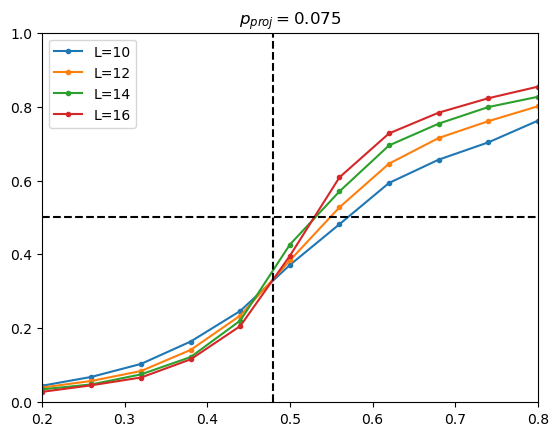

In [ ]:
fig,ax=plt.subplots()
p_proj_idx=3
for i in range(O_map.shape[0]):
    ax.plot(p_ctrl_list,O_map[i,:,p_proj_idx].mean(axis=-1),'.-',label=f'L={L_list[i]}')
ax.legend()
ax.axvline(x=0.48,ls='dashed',color='k')
ax.axhline(y=0.5,ls='dashed',color='k')
ax.set_xlim([.2,.8])
ax.set_ylim([0,1])
ax.set_title(f'$p_{{proj}}={p_proj_list[p_proj_idx]:.3f}$')

Text(0.5, 1.0, '$p_{proj}=0.100$')

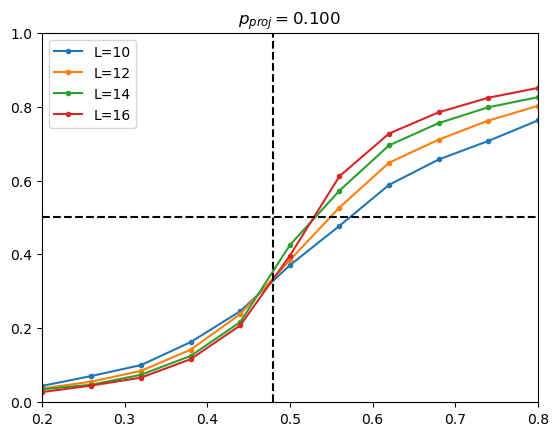

In [ ]:
fig,ax=plt.subplots()
p_proj_idx=4
for i in range(O_map.shape[0]):
    ax.plot(p_ctrl_list,O_map[i,:,p_proj_idx].mean(axis=-1),'.-',label=f'L={L_list[i]}')
ax.legend()
ax.axvline(x=0.48,ls='dashed',color='k')
ax.axhline(y=0.5,ls='dashed',color='k')
ax.set_xlim([.2,.8])
ax.set_ylim([0,1])
ax.set_title(f'$p_{{proj}}={p_proj_list[p_proj_idx]:.3f}$')

Text(0.5, 1.0, '$p_{proj}=0.000$')

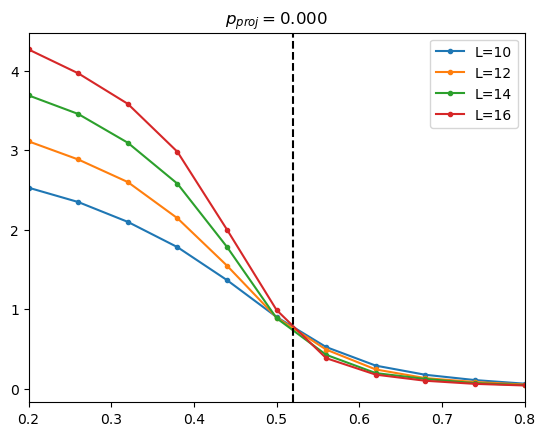

In [ ]:
fig,ax=plt.subplots()
p_proj_idx=0
for i in range(EE_map.shape[0]):
    ax.plot(p_ctrl_list,EE_map[i,:,p_proj_idx].mean(axis=-1),'.-',label=f'L={L_list[i]}')
ax.legend()
ax.axvline(x=0.52,ls='dashed',color='k')
ax.set_xlim([.2,.8])
ax.set_title(f'$p_{{proj}}={p_proj_list[p_proj_idx]:.3f}$')

Text(0.5, 1.0, '$p_{proj}=0.025$')

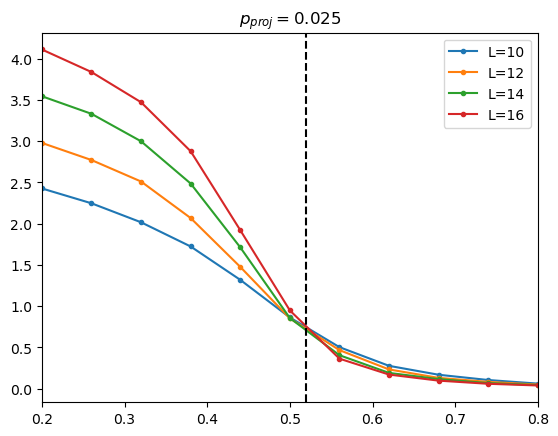

In [ ]:
fig,ax=plt.subplots()
p_proj_idx=1
for i in range(EE_map.shape[0]):
    ax.plot(p_ctrl_list,EE_map[i,:,p_proj_idx].mean(axis=-1),'.-',label=f'L={L_list[i]}')
ax.legend()
ax.axvline(x=0.52,ls='dashed',color='k')
ax.set_xlim([.2,.8])
ax.set_title(f'$p_{{proj}}={p_proj_list[p_proj_idx]:.3f}$')

Text(0.5, 1.0, '$p_{proj}=0.050$')

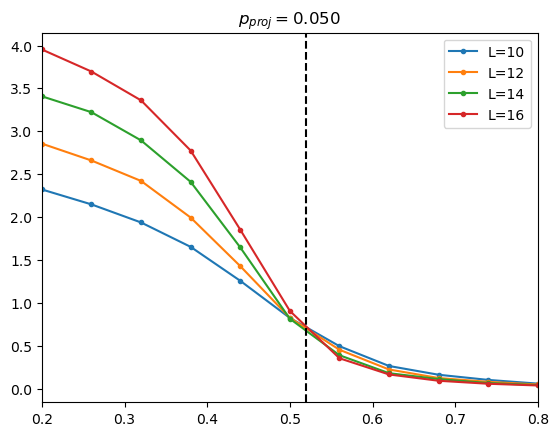

In [ ]:
fig,ax=plt.subplots()
p_proj_idx=2
for i in range(EE_map.shape[0]):
    ax.plot(p_ctrl_list,EE_map[i,:,p_proj_idx].mean(axis=-1),'.-',label=f'L={L_list[i]}')
ax.legend()
ax.axvline(x=0.52,ls='dashed',color='k')
ax.set_xlim([.2,.8])
ax.set_title(f'$p_{{proj}}={p_proj_list[p_proj_idx]:.3f}$')

Text(0.5, 1.0, '$p_{proj}=0.075$')

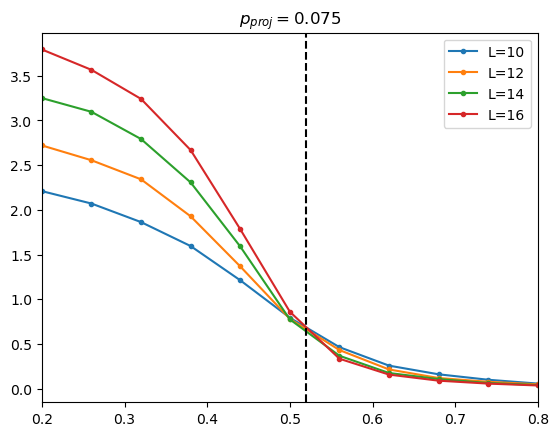

In [ ]:
fig,ax=plt.subplots()
p_proj_idx=3
for i in range(EE_map.shape[0]):
    ax.plot(p_ctrl_list,EE_map[i,:,p_proj_idx].mean(axis=-1),'.-',label=f'L={L_list[i]}')
ax.legend()
ax.axvline(x=0.52,ls='dashed',color='k')
ax.set_xlim([.2,.8])
ax.set_title(f'$p_{{proj}}={p_proj_list[p_proj_idx]:.3f}$')

Text(0.5, 1.0, '$p_{proj}=0.100$')

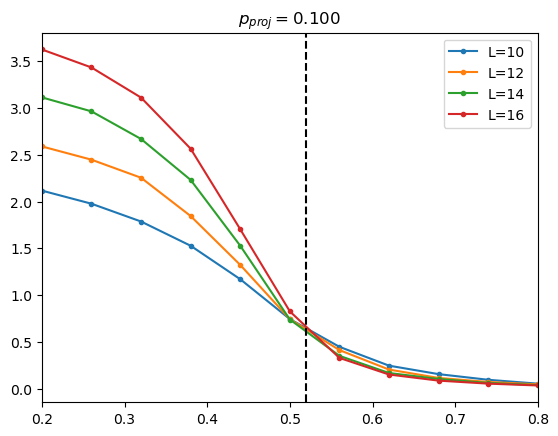

In [ ]:
fig,ax=plt.subplots()
p_proj_idx=4
for i in range(EE_map.shape[0]):
    ax.plot(p_ctrl_list,EE_map[i,:,p_proj_idx].mean(axis=-1),'.-',label=f'L={L_list[i]}')
ax.legend()
ax.axvline(x=0.52,ls='dashed',color='k')
ax.set_xlim([.2,.8])
ax.set_title(f'$p_{{proj}}={p_proj_list[p_proj_idx]:.3f}$')